<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Pytorch Workflow

In [70]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
torch.__version__

'1.13.1+cu116'

There are a few steps that we are going to conduct when facing a Deep Learning model in PyTorch:

1) Prepare and load the data

2) Build the model architecture

3) Fit the model to the data

4) Make model predictions and evaluate the model

5) Save/Re-load the model

6) Put it all into a pipeline

## Prepare and load the data

Preparing the data refers to converting our data (images, text, audio, video, etc.) to tensors (numerical representation) that can be fed to the ML/DL model.

Let's create an artificial dataset using the Linear Regression formula:

$y = a + bx$

In [3]:
weight = 0.7
bias = 0.3

Create synthetic data:

In [4]:
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
len(X), len(y)

(50, 50)

In [6]:
X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

## Splitting the Data

In [8]:
train_split = int(0.8 * len(X))
train_split

40

In [9]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test   = X[train_split:], y[train_split:]

In [12]:
len(X_train), len(y_train)

(40, 40)

In [13]:
len(X_test), len(y_test)

(10, 10)

## Visualizing the Data

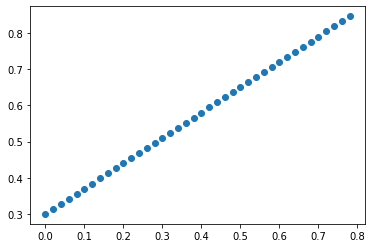

In [16]:
plt.scatter(X_train, y_train)

In [21]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions):
  """Plots train and test data, and compares predictions"""
  plt.figure(figsize=(10, 7))

  # Train data
  plt.scatter(train_data, train_labels, c='b', s=7, label='Training data')

  # Test data
  plt.scatter(test_data, test_labels, c='g', s=7, label='Testing data')

  # Check for preds
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=7, label='Predictions')

  plt.legend(prop={'size': 14})

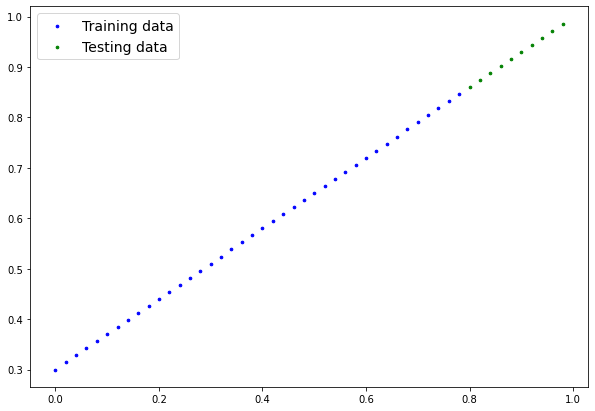

In [22]:
plot_predictions(X_train, y_train, X_test, y_test, None)

## Building a simple PyTorch model to predict this

In [31]:
class LinearRegressionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Set the weight of the linear model
    self.weights = torch.nn.Parameter(
        torch.randn(1, requires_grad=True, dtype=torch.float)
    )

    # Set the bias of the linear model
    self.bias = torch.nn.Parameter(
        torch.randn(1, requires_grad=True, dtype=torch.float)
    )

  # Define the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### Summary of building blocks for PyTorch models:

* torch.nn - Contains all of the building blocks for neural networks
* torch.nn.Parameter - Defines a parameter that our model will try to optimize. These are generally set up automatically in the PyTorch layers. But if you are doing it manually, you should set the parameters you want your model to optimize.
* torch.nn.Module - The base class for neural network modules. Remember to overwrite the forward() method with your model's forward pass.
* torch.optim - This is where the optimizers can be found in PyTorch. Building blocks for gradient descent.
* torch.utils.data.Dataset - Represents a map  between keys (label) and samples (features) pairs in your data. For example, images associated with labels
* torch.utils.data.DataLoader - Creates a Python iterable over a torch Dataset. This is used for training.


## Checking model insights

In [33]:
# Set the seed for reproducibility
torch.manual_seed(42)

model = LinearRegressionModel()

In [34]:
model.parameters() # This shows a generator object

<generator object Module.parameters at 0x7f11f58620b0>

In [35]:
# Convert the generator into a list for visualization
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

A better way to visualize this when parameters are simple is by using the state_dict() method. This shows us the "named" parameters. The names are simply the attributes to which the parameters are set, but it helps understanding them better.

In [36]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions with the randomly initialized model

To check the predictive power, we want to measure how well our model predicts y_test, given X_test. Note we are using **torch.inference_mode()** instead of **torch.no_grad()**. The inference mode is a later implementation of the torch.no_grad() context manager, that allows for faster computations.

The difference between them can be found [here](https://twitter.com/PyTorch/status/1437838231505096708?s=20). But basically the inference_mode() context handler removes some extra operations from the no_grad() counterpart, so it can compute predictions even faster.

In [37]:
# This doesn't keep track of gradients, 
# so computing predictions is faster

with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

#### Comparing the output of our model to the expected output

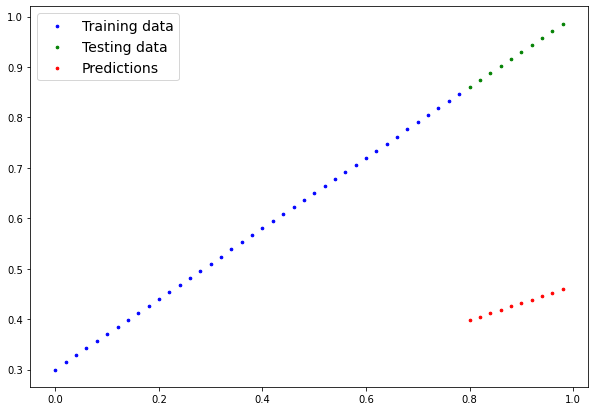

In [38]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

## Training the Linear Regression model:

We want our model to optimize the weight and bias to be as similar as the data as possible. We know weigth = 0.7, and bias = 0.3, so our model is pretty far off. We want these parameters to get closer to them.

We will do that by implementing a loss function that calculates the errors that our model makes and quantifies how "bad" they are. This loss function will perform backpropagation and propagate the error over the different parameters to adjust them to minimize the loss function.

We will implement a optimizer as well. The optimizer uses the learning rate to propagate the error over the different parameters to adjust them to minimize the loss function.

### In PyTorch, we need:

- A Training loop that makes model predictions, calculates the loss function and backpropagates the error.
- A Testing loop that evaluates how our model is performing on unseen data.

In [39]:
# Loss function (MAE)
loss_fn = torch.nn.L1Loss()

# Optimizer (Stochastic Gradient Descent)
lr = 0.01  # Learning Rate
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

### Building the training/testing loop

Steps to build a training loop:

1. Loop through data
2. Perform forward pass. Pass the data through the forward() method.
3. Calculate the loss. Measure how far off our predictions are from the labels.
4. Optimizer zero_grad. The optimizers by default accumulate the step they move in the opposite direction of the gradient. So you need to explicitly zero it for the next step to be only the result of the current iteration's optimiser step. If not, the step will become bigger and bigger every time.
5. Loss backward(). This performs the actual calculation of gradients for each parameter by calculating the derivative of the parameter with respect to the loss function.
6. Optimizer step. Our optimizer determined how much we need to move in order to minimize the loss function

### Just the training loop

In [40]:
# check model's initial parameters before trianing
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [53]:
epochs = 20

for epoch in range(epochs):
  # Set the model to training mode
  ## Train mode sets all parameters to requires_grad=True
  model.train()

  # Forward pass
  y_pred = model(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(loss.item()) # This is just for visualization purposes (not present in real training loops)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Step the optimizer (Gradient Descent)
  optimizer.step() 

  model.eval()

  print(model.state_dict()) 

0.1515873372554779
OrderedDict([('weights', tensor([0.3952])), ('bias', tensor([0.2788]))])
0.14006635546684265
OrderedDict([('weights', tensor([0.3991])), ('bias', tensor([0.2888]))])
0.1285453587770462
OrderedDict([('weights', tensor([0.4030])), ('bias', tensor([0.2988]))])
0.11702437698841095
OrderedDict([('weights', tensor([0.4069])), ('bias', tensor([0.3088]))])
0.1060912236571312
OrderedDict([('weights', tensor([0.4108])), ('bias', tensor([0.3178]))])
0.09681284427642822
OrderedDict([('weights', tensor([0.4146])), ('bias', tensor([0.3258]))])
0.08908725529909134
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
0.08227583020925522
OrderedDict([('weights', tensor([0.4222])), ('bias', tensor([0.3403]))])
0.07638873159885406
OrderedDict([('weights', tensor([0.4258])), ('bias', tensor([0.3463]))])
0.07160007208585739
OrderedDict([('weights', tensor([0.4293])), ('bias', tensor([0.3518]))])
0.06747635453939438
OrderedDict([('weights', tensor([0.4328])), ('bias', 

In [54]:
with torch.inference_mode():
  y_preds_trained = model(X_test)

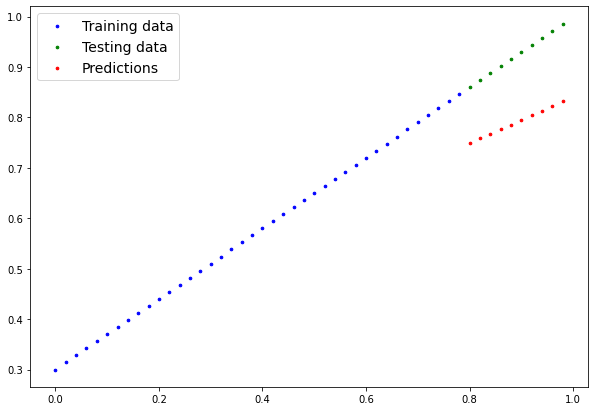

In [55]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds_trained)

### Comments on model.train() vs model.eval()

PyTorch offers a model.train() and a model.eval() method. These methods allow the user to switch between training mode, which is purposefully optimized for training the model, vs evaluate mode, which is purposefully optimized for performing inference with the model.

- **Training mode:** Sets all the requires_grad attributes of all parameters in the model to True. So that gradients are tracked through the model.
```python
model.train()
```
- **Evaluation mode:** Turns off dropout layers and batch normalization layers
```python
model.eval()
```

### Training and testing loops combined

Below we are restarting the model. We initialize it again with the same seed, so the training loop will be getting the same results. But after the training we will add the testing loop for testing our model on a dataset our model hasn't seen before.

We can also add a visualization for the training loss and test loss, so we know how good our model is getting, and if we are overfitting. This is done by adding the training and test loss to a list which we will later use for ploting:

```python
epoch_count = []
acc_loss_train = []
acc_loss_test  = []

... (code that executes training) ...

if epoch % 10 == 0:
  epoch_count.append(epoch)
  acc_loss_train.append(loss.item())
  acc_loss_test.append(loss_valid.item())
  print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Test loss: {loss_valid.item()}")
```

In [61]:
# Set the seed for reproducibility
torch.manual_seed(42)

model = LinearRegressionModel()

In [62]:
# Loss function (MAE)
loss_fn = torch.nn.L1Loss()

# Optimizer (Stochastic Gradient Descent)
lr = 0.01  # Learning Rate
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

In [63]:
epochs = 150

epoch_count = []
acc_loss_train = []
acc_loss_test  = []

for epoch in range(epochs):
  ## TRAINING

  # Set the model to training mode
  ## Train mode sets all parameters to requires_grad=True
  model.train()

  # Forward pass
  y_pred = model(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Step the optimizer (Gradient Descent)
  optimizer.step() 

  ## TESTING
  model.eval()

  with torch.inference_mode():
    test_pred = model(X_test)
    loss_valid = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Test loss: {loss_valid.item()}")
    epoch_count.append(epoch)
    acc_loss_train.append(loss.item())
    acc_loss_test.append(loss_valid.item())

Epoch: 0 | Train Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Train Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Train Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Train Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Train Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Train Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Train Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Train Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Train Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Train Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Train Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Train Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Train Loss: 0.01758546568453312 | Test loss: 0.040604822337627

In [64]:
model.state_dict() 
# Remember weights should be close to 0.7 and bias to 0.3

OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

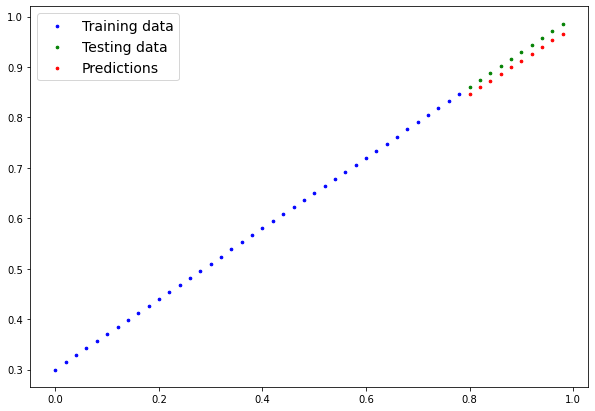

In [65]:
plot_predictions(X_train, y_train, X_test, y_test, test_pred)

This can be improved by training again. But one may ask if it's necessary to go over 100 epochs, it seems like a lot. This may be a time to also experiment with learning rates, as higher learning rates will make higher "step" adjustments.

### Visualizing the loss progression

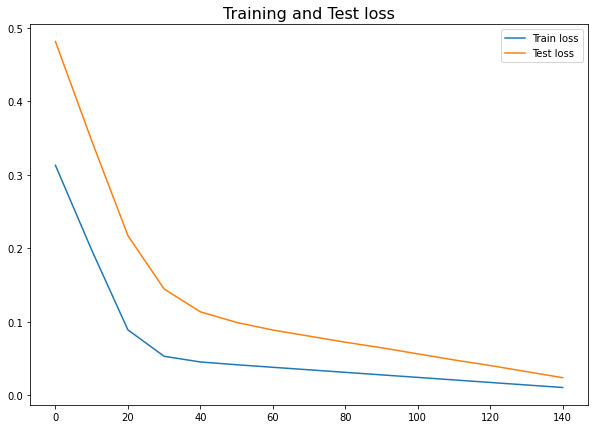

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(epoch_count, acc_loss_train, label='Train loss')
ax.plot(epoch_count, acc_loss_test, label='Test loss')
ax.set_title('Training and Test loss', fontdict={'size': 16})

ax.legend();

## Saving a PyTorch model

There are three functions for saving and loading models:

1. **torch.save():** Saves a serialized object of the model in Python pickle.
2. **torch.load():** Load a serialized model object from Python pickle.
3. **torch.nn.Module.load_state_dict():** Load a model's saved state (its parameter dictionary).

The recommended way to save this is by saving the state dict (only the models trained parameters) instead of the entire model.

Also note that the pytorch.save() takes an f argument which is, according to the documentation a file-like object OR an os.PathLike object containing a path.

In [73]:
model_path = pathlib.Path('models')
model_path.mkdir(parents=True, exist_ok=True)

model_name = 'linear_regression_model.pth' # .pth or .pt is the standard extension of PyTorch models
model_save_path = model_path / model_name # pathlib allows for this syntax

print(f"saving model to: {model_save_path}")

torch.save(
    model.state_dict(), f=model_save_path
)

saving model to: models/linear_regression_model.pth


**Important Note (1):** Note that you now have the model saved in the "files" directory, under the "models" folder. This will also be the case if you run this locally instead of running it in Google colab.

**Important Note (2):** Also note that we save the **model state dict** and not the entire model. So when we load the model, we will be loading the pre-saved state onto a model with the same architecture.

In [75]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1191 Feb  6 11:46 linear_regression_model.pth


In [76]:
!ls -1 models

linear_regression_model.pth


## Loading a PyTorch model

In [79]:
loaded_model_dict = torch.load(model_save_path)

loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(loaded_model_dict)

<All keys matched successfully>

We can also do this in a single line:

In [82]:
loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [83]:
loaded_model.eval()

with torch.inference_mode():
  preds = loaded_model(X_test)

preds

tensor([[0.8464],
        [0.8596],
        [0.8729],
        [0.8862],
        [0.8995],
        [0.9127],
        [0.9260],
        [0.9393],
        [0.9526],
        [0.9659]])

# Putting everything together (with device agnostic code)

In [84]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

device

'cpu'